In [4]:
import os
import gensim
from gensim import utils
from tqdm.notebook import tqdm
from sklearn.neighbors import kneighbors_graph
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
class Dataloader:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    yield utils.simple_preprocess(f.read())
sentences = Dataloader()

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size=128, min_count=1)

In [28]:
#word2vec.save('word2vec_model')
word2vec = gensim.models.Word2Vec.load('word2vec_model')

In [29]:
word2vec.wv.most_similar(positive='царь', topn=10)

[('король', 0.823395848274231),
 ('царевич', 0.8209406137466431),
 ('патриарх', 0.8094379901885986),
 ('престол', 0.7853482365608215),
 ('государь', 0.7745516300201416),
 ('император', 0.7719162106513977),
 ('иоанн', 0.7696580290794373),
 ('владыка', 0.7589395642280579),
 ('православный', 0.7550569772720337),
 ('годунов', 0.7452263832092285)]

In [30]:
from collections import Counter
from time import time

graphs = []
t0 = time()
for sentence in sentences:
    if not sentence:
        continue
    nodes = []
    top10 = Counter(sentence).most_common(10)
    for word, freq in top10:
        top10_wv = word2vec.wv.most_similar(positive=word, topn=10)
        nodes.append(word)
        for syn, vec in top10_wv:
            nodes.append(syn)
    adj = kneighbors_graph(word2vec.wv[nodes], n_neighbors=5, metric='minkowski', p=2)
    graph = nx.from_scipy_sparse_array(adj)
    mapping = {i: token for i, token in enumerate(nodes)}
    graph = nx.relabel_nodes(graph, mapping)
    graph.remove_edges_from(nx.selfloop_edges(graph))
    graphs.append(graph)

print(f"graphs built in {time() - t0:.3f} s")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

graphs built in 472.948 s


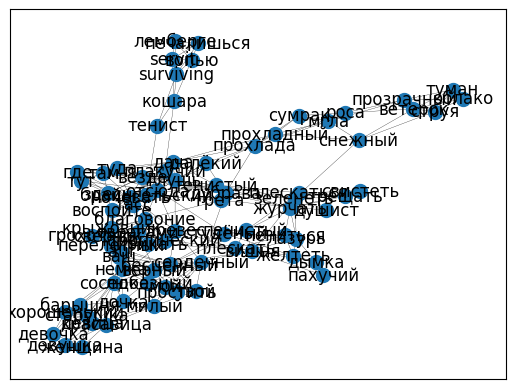

In [31]:
nx.draw_networkx(graphs[0], node_size=100, width=0.2)
#plt.xlim(-0.07, 0.03)
#plt.ylim(-0.05, 0.05)

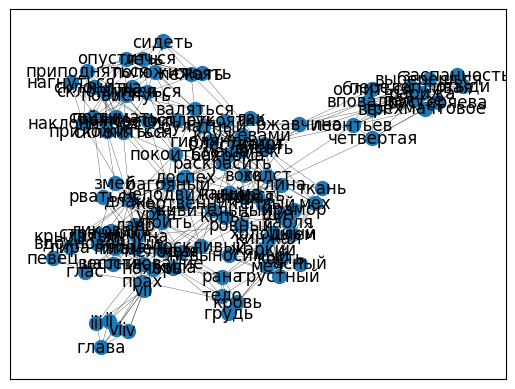

In [32]:
nx.draw_networkx(graphs[1], node_size=100, width=0.2)

In [9]:
sent_len = [len(sent) for sent in sentences if sent]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [39]:
print(len(graphs))
print(len(sent_len))

1826
1826


In [46]:
from tqdm import tqdm

sent_features = []

for num, graph in tqdm(enumerate(graphs)):
    text_len = sent_len[num]
    node_num = len(graph.nodes)
    edge_num = len(graph.edges)
    avg_clust_coef = nx.average_clustering(graph)
    largest_cc = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
    radius = nx.radius(largest_cc)
    diameter = nx.diameter(largest_cc)
    shortest_path_len = nx.average_shortest_path_length(largest_cc)
    avg_node_con = nx.average_node_connectivity(graph)
    #degree_cent = nx.degree_centrality(graph)
    #closeness = nx.closeness_centrality(graph)
    #betweenness = nx.betweenness_centrality(graph)
    #eigen = nx.eigenvector_centrality(graph)
    #katz = nx.katz_centrality_numpy(graph)
    features = [text_len, node_num, edge_num, avg_clust_coef, radius, diameter, shortest_path_len, avg_node_con]
    sent_features.append(features)

1826it [18:46:48, 37.03s/it] 


In [58]:
true_labels = []

class Genres:
    def __iter__(self):
        for genre in tqdm(['ballads', 'elegies', 'songs', 'novels'], leave=True):
            for file in tqdm(os.listdir('../datasets/lemmatized/' + genre), leave=False):
                with open('../datasets/lemmatized/' + genre + '/' + file, 'r', encoding='utf-8') as f:
                    if utils.simple_preprocess(f.read()):
                        yield genre
genres_true = Genres()

for gen in genres_true:
    true_labels.append(gen)

100%|██████████| 4/4 [01:02<00:00, 15.71s/it]


In [59]:
len(true_labels)

1826

In [169]:
import pickle

#with open('sent_features.pickle', 'wb') as f:
#    pickle.dump(sent_features, f)

with open('sent_features.pickle', 'rb') as f:
    sent_features = pickle.load(f)

#with open('true_labels.pickle', 'wb') as f:
#    pickle.dump(true_labels, f)

with open('true_labels.pickle', 'rb') as f:
    true_labels = pickle.load(f)

In [5]:
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(true_labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(true_labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(true_labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(true_labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [6]:
from sklearn.cluster import KMeans

X = np.array(sent_features)

kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X)

clustering done in 0.04 ± 0.06 s 
Homogeneity: 0.359 ± 0.007
Completeness: 0.622 ± 0.009
V-measure: 0.455 ± 0.008
Adjusted Rand-Index: 0.258 ± 0.007
Silhouette Coefficient: 0.837 ± 0.002


In [10]:
import pandas as pd

labels_to_int = {'songs': 0,
                 'ballads': 1,
                 'elegies': 2,
                 'novels': 3}
int_true_labels = []
for label in true_labels:
    int_true_labels.append(labels_to_int[label])

data = {'true_label': int_true_labels,
        'text_len': np.array(sent_features)[:,0],
        'node_num': np.array(sent_features)[:,1],
        'edge_num': np.array(sent_features)[:,2],
        'avg_clust_coef': np.array(sent_features)[:,3],
        'radius': np.array(sent_features)[:,4],
        'diameter': np.array(sent_features)[:,5],
        'shortest_path_len': np.array(sent_features)[:,6],
        'avg_node_con': np.array(sent_features)[:,7]}
df = pd.DataFrame(data)
df.corr(method='pearson')

,true_label,text_len,node_num,edge_num,avg_clust_coef,radius,diameter,shortest_path_len,avg_node_con
true_label,1.000000,0.520077,-0.518387,-0.488827,-0.469014,-0.375919,-0.467768,-0.512256,-0.049071
text_len,0.520077,1.000000,-0.468405,-0.470850,-0.314957,-0.240142,-0.320801,-0.311508,-0.165029
node_num,-0.518387,-0.468405,1.000000,0.947005,0.479599,0.162466,0.287934,0.323492,0.343546
edge_num,-0.488827,-0.470850,0.947005,1.000000,0.313162,0.055190,0.183419,0.173855,0.516422
avg_clust_coef,-0.469014,-0.314957,0.479599,0.313162,1.000000,0.475387,0.559675,0.659574,-0.430430
radius,-0.375919,-0.240142,0.162466,0.055190,0.475387,1.000000,0.834512,0.801508,-0.361705
diameter,-0.467768,-0.320801,0.287934,0.183419,0.559675,0.834512,1.000000,0.900647,-0.364025
shortest_path_len,-0.512256,-0.311508,0.323492,0.173855,0.659574,0.801508,0.900647,1.000000,-0.438656
avg_node_con,-0.049071,-0.165029,0.343546,0.516422,-0.430430,-0.361705,-0.364025,-0.438656,1.000000


permutation importance from: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html and https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

In [103]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    kmeans, X, int_true_labels, n_repeats=10, random_state=42, n_jobs=2
)

importances = pd.Series(result.importances_mean, index=['text_len', 'node_num', 'edge_num', 'avg_clust_coef', 'radius', 'diameter', 'shortest_path_len', 'avg_node_con'])

In [104]:
importances

text_len             2.466838e+06
node_num             3.479855e+04
edge_num             2.426361e+06
avg_clust_coef       1.056671e+00
radius               2.014628e+02
diameter             1.275733e+03
shortest_path_len    9.412158e+01
avg_node_con         5.789055e+01
dtype: float64

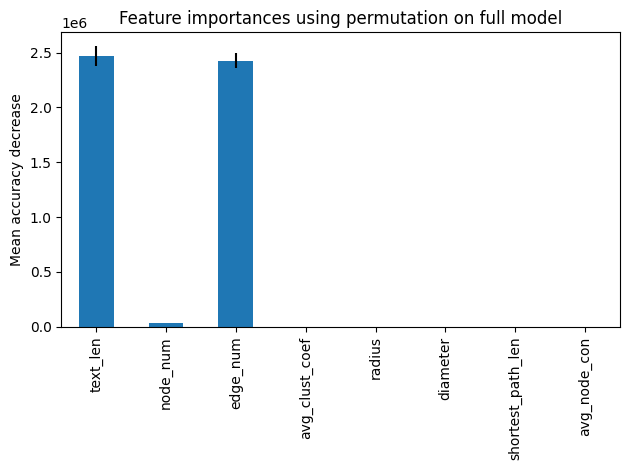

In [106]:
fig, ax = plt.subplots()
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

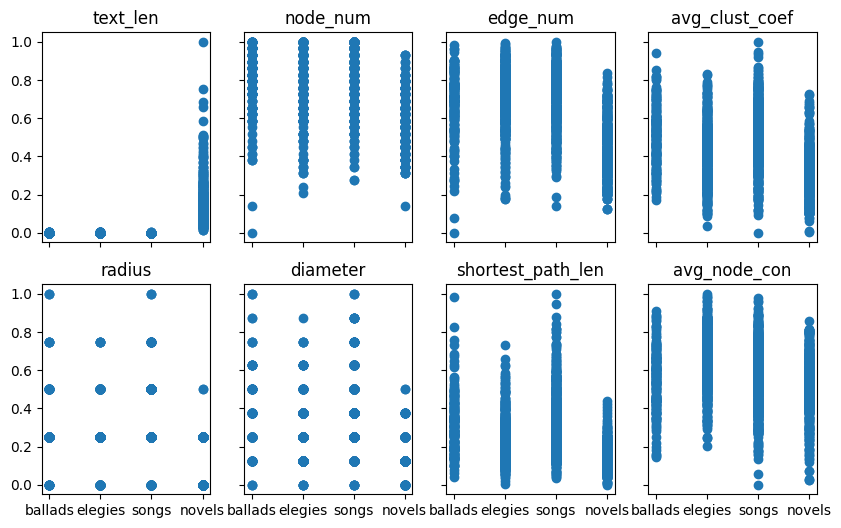

In [38]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6))

def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

axs[0, 0].scatter(true_labels, normalize(np.array(sent_features)[:,0]))
axs[0, 0].set_title('text_len')
axs[0, 1].scatter(true_labels, normalize(np.array(sent_features)[:,1]))
axs[0, 1].set_title('node_num')
axs[0, 2].scatter(true_labels, normalize(np.array(sent_features)[:,2]))
axs[0, 2].set_title('edge_num')
axs[0, 3].scatter(true_labels, normalize(np.array(sent_features)[:,3]))
axs[0, 3].set_title('avg_clust_coef')
axs[1, 0].scatter(true_labels, normalize(np.array(sent_features)[:,4]))
axs[1, 0].set_title('radius')
axs[1, 1].scatter(true_labels, normalize(np.array(sent_features)[:,5]))
axs[1, 1].set_title('diameter')
axs[1, 2].scatter(true_labels, normalize(np.array(sent_features)[:,6]))
axs[1, 2].set_title('shortest_path_len')
axs[1, 3].scatter(true_labels, normalize(np.array(sent_features)[:,7]))
axs[1, 3].set_title('avg_node_con')

for ax in axs.flat:
    ax.label_outer()

In [35]:
core_nodes = []

for sentence in sentences:
    if not sentence:
        continue
    core_nodes_sent = [i[0] for i in Counter(sentence).most_common(10)]
    core_nodes.append(core_nodes_sent)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [83]:
rel_freqs = []

for sentence in sentences:
    if not sentence:
        continue
    freqs = Counter(sentence)
    rel_freqs_sent = {}
    for i in freqs:
        rel_freqs_sent[i] = freqs[i]/len(sentence)
    rel_freqs.append(rel_freqs_sent)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/509 [00:00<?, ?it/s]

  0%|          | 0/623 [00:00<?, ?it/s]

  0%|          | 0/506 [00:00<?, ?it/s]

In [100]:
len(rel_freqs)

1826

In [108]:
# counts
core_edges = []
multiple_nodes = []
multiple_edges = []
boundary_nodes = []
boundary_edges = []

# node weights equal to relative word frequencies in each text
core_nodes_weights = []
multiple_nodes_weigths = []
boundary_nodes_weights = []

# core weights equal to the cosine similarity between the nodes
core_edges_weights = []
multiple_edges_weights = []
boundary_edges_weights = []

# core node degrees separated into three categories: counting only core edges, only multiple edges, only boundary edges
core_node_core_edge_degree = []
core_nodes_multiple_edge_degree = []
core_nodes_boundary_edge_degree = []

for num, graph in enumerate(graphs):

    num_core_edges = 0
    multiple_nodes_graph = 0
    multiple_edges_graph = 0
    boundary_nodes_graph = 0
    boundary_edges_graph = 0

    core_edges_weights_sent = []
    multiple_edges_weights_sent = []
    boundary_edges_weights_sent = []

    multiple_nodes_weigths_sent = []
    boundary_nodes_weights_sent = []

    core_nodes_graph = core_nodes[num]
    core_nodes_weights_sent = [rel_freqs[num][i] for i in core_nodes_graph]
    core_pairs = [(a, b) for idx, a in enumerate(core_nodes_graph) for b in core_nodes_graph[idx + 1:]]
    for pair in core_pairs:
        num_core_edges += graph.has_edge(pair[0], pair[1])
        core_edge_w = word2vec.wv.similarity(pair[0], pair[1])
        core_edges_weights_sent.append(core_edge_w)
    core_edges.append(num_core_edges)

    for node in graph.nodes:
        node_to_core_edge = 0
        boundary_nodes_weight_sent = []
        multiple_nodes_weight_sent = []

        if node not in core_nodes_graph:
            for core_node in core_nodes_graph:
                node_to_core_edge += graph.has_edge(node, core_node)
            if node_to_core_edge == 1:
                boundary_nodes_graph += 1
                boundary_edges_graph += 1
                if node in rel_freqs[num]:
                    boundary_nodes_weights_sent.append(rel_freqs[num][node])
                core = [i[1] for i in graph.edges(node)][0]
                boundary_edges_weights_sent.append(word2vec.wv.similarity(node, core))
            elif node_to_core_edge >= 1:
                multiple_nodes_graph += 1
                multiple_edges_graph += node_to_core_edge
                if node in rel_freqs[num]:
                    multiple_nodes_weigths_sent.append(rel_freqs[num][node])
                cores = [i[1] for i in graph.edges(node)]
                for core in cores:
                    multiple_edges_weights_sent.append(word2vec.wv.similarity(node, core))

    core_node_core_edge_sent = []
    core_nodes_multiple_edge_sent = []
    core_nodes_boundary_edge_sent = []
    
    for node in graph.nodes:
        edges = graph.edges(i[1] for i in graphs[0].edges(node))
        if node in core_nodes_graph:
            core_node_core_edges = 0
            core_node_multiple_edges = 0
            core_node_boundary_edges = 0
            for edge in edges:
                if edge in core_nodes_graph:
                    core_node_core_edges += 1
                elif len(edges) == 1:
                    core_node_boundary_edges = 1
                else:
                    core_node_multiple_edges += 1
            core_node_core_edge_sent.append(core_node_core_edges)
            core_nodes_multiple_edge_sent.append(core_node_multiple_edges)
            core_nodes_boundary_edge_sent.append(core_node_boundary_edges)
    
    multiple_nodes.append(multiple_nodes_graph)
    multiple_edges.append(multiple_edges_graph)
    boundary_nodes.append(boundary_nodes_graph)
    boundary_edges.append(boundary_edges_graph)

    core_nodes_weights.append(core_nodes_weights_sent)
    multiple_nodes_weigths.append(multiple_nodes_weigths_sent)
    boundary_nodes_weights.append(boundary_nodes_weights_sent)

    core_edges_weights.append(core_edges_weights_sent)
    multiple_edges_weights.append(multiple_edges_weights_sent)
    boundary_edges_weights.append(boundary_edges_weights_sent)

    core_node_core_edge_degree.append(core_node_core_edge_sent)
    core_nodes_multiple_edge_degree.append(core_nodes_multiple_edge_sent)
    core_nodes_boundary_edge_degree.append(core_nodes_boundary_edge_sent)

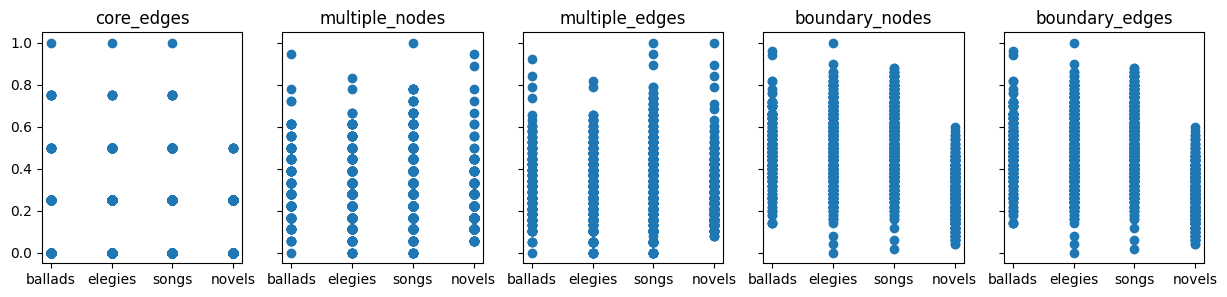

In [72]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

axs[0].scatter(true_labels, normalize(np.array(core_edges)))
axs[0].set_title('core_edges')
axs[1].scatter(true_labels, normalize(np.array(multiple_nodes)))
axs[1].set_title('multiple_nodes')
axs[2].scatter(true_labels, normalize(np.array(multiple_edges)))
axs[2].set_title('multiple_edges')
axs[3].scatter(true_labels, normalize(np.array(boundary_nodes)))
axs[3].set_title('boundary_nodes')
axs[4].scatter(true_labels, normalize(np.array(boundary_edges)))
axs[4].set_title('boundary_edges')

for ax in axs.flat:
    ax.label_outer()

In [171]:
# new features
# number of core/multiple/boundary nodes/edges

features = []
features.append(core_edges)
features.append(multiple_nodes)
features.append(multiple_edges)
features.append(boundary_nodes)
features.append(boundary_edges)

# min/max/avg/sum of core/multiple/boundary node weight, edge weight

features.append([min(x, default=0) for x in core_nodes_weights])
features.append([min(x, default=0) for x in multiple_nodes_weigths])
features.append([min(x, default=0) for x in boundary_nodes_weights])

features.append([min(x, default=0) for x in core_edges_weights])
features.append([min(x, default=0) for x in multiple_edges_weights])
features.append([min(x, default=0) for x in boundary_edges_weights])

features.append([max(x, default=0) for x in core_nodes_weights])
features.append([max(x, default=0) for x in multiple_nodes_weigths])
features.append([max(x, default=0) for x in boundary_nodes_weights])

features.append([max(x, default=0) for x in core_edges_weights])
features.append([max(x, default=0) for x in multiple_edges_weights])
features.append([max(x, default=0) for x in boundary_edges_weights])

features.append([np.average(x) for x in core_nodes_weights])
features.append([np.average(x) for x in multiple_nodes_weigths])
features.append([np.average(x) for x in boundary_nodes_weights])

features.append([sum(x) for x in core_edges_weights])
features.append([sum(x) for x in multiple_edges_weights])
features.append([sum(x) for x in boundary_edges_weights])

# count/min/max/avg core nodes degree

features.append([min(x, default=0) for x in core_node_core_edge_degree])
features.append([min(x, default=0) for x in core_nodes_multiple_edge_degree])
features.append([min(x, default=0) for x in core_nodes_boundary_edge_degree])

features.append([max(x, default=0) for x in core_node_core_edge_degree])
features.append([max(x, default=0) for x in core_nodes_multiple_edge_degree])
features.append([max(x, default=0) for x in core_nodes_boundary_edge_degree])

features.append([np.average(x) for x in core_node_core_edge_degree])
features.append([np.average(x) for x in core_nodes_multiple_edge_degree])
features.append([np.average(x) for x in core_nodes_boundary_edge_degree])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [173]:
sent_features_new = sent_features.copy()

for num, sent in enumerate(sent_features_new):
    for i in features:
        sent_features_new[num].append(i[num])

In [174]:
np.array(sent_features).shape

(1826, 40)

In [175]:
np.array(sent_features_new).shape

(1826, 40)

In [181]:
sent_features_new[0]

[217,
 81,
 261,
 0.4842542231431121,
 5,
 10,
 3.7280864197530863,
 3.8410493827160495,
 3,
 3,
 6,
 42,
 42,
 0.02304147465437788,
 0.009216589861751152,
 0.004608294930875576,
 -0.09045152,
 0.4824291,
 -0.19088978,
 0.03686635944700461,
 0.009216589861751152,
 0.02304147465437788,
 0.9581768,
 0.9202832,
 0.9373901,
 0.02903225806451613,
 0.009216589861751152,
 0.01075268817204301,
 21.563222110271454,
 13.307403206825256,
 27.976882442831993,
 0,
 4,
 0,
 0,
 50,
 0,
 0.0,
 27.7,
 0.0]

In [177]:
X = np.array(sent_features_new)
X = np.nan_to_num(X)

kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X)

clustering done in 0.04 ± 0.05 s 
Homogeneity: 0.359 ± 0.007
Completeness: 0.622 ± 0.009
V-measure: 0.455 ± 0.008
Adjusted Rand-Index: 0.258 ± 0.007
Silhouette Coefficient: 0.837 ± 0.002


In [178]:
X = np.array(np.transpose(np.array(features)))
X = np.nan_to_num(X)

kmeans = KMeans(
    n_clusters=4,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X)

clustering done in 0.02 ± 0.02 s 
Homogeneity: 0.131 ± 0.036
Completeness: 0.131 ± 0.033
V-measure: 0.131 ± 0.034
Adjusted Rand-Index: 0.136 ± 0.041
Silhouette Coefficient: 0.336 ± 0.000
